<a href="https://colab.research.google.com/github/thadduslee/EGARCH-Sentiment-Analysis-GMMHMM-for-Volatility-Prediction-and-Portfolio-Optimisation/blob/main/NUS_Fintech_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
pip install arch

In [76]:
pip install hmmlearn

<a href="https://colab.research.google.com/github/thadduslee/EGARCH-model-XGBoost-optimal-portfolio-construction-Markowitz-Portfolio-Theory-Monte-Carlo/blob/main/Fintech_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import yfinance as yf
import numpy as np
from arch import arch_model
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Reddit scraping bot

In [78]:
#def reddit_scraper(ticker):

Sentiment Analysis Engine

In [79]:
#def sentiment_analysis(ticker):

Volatility Prediction

In [80]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GMMHMM
import matplotlib.pyplot as plt
import seaborn as sns
probability_distributions = {}
transition_matrix = []
def hidden_markov_model_gmm(ticker):
    # 1. Get Data
    data = yf.download(ticker, start="2015-01-01", progress=False)
    # Handle multi-index if necessary
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, level=1, axis=1) if ticker in data.columns.levels[1] else data

    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)

    X = data['Log_Returns'].values.reshape(-1, 1)

    # 2. Setup GMMHMM
    # n_mix=2: Each state is a mix of 2 Gaussian distributions (helps capture fat tails)
    model = GMMHMM(n_components=3, n_mix=2, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(X)

    # 3. Fix Sorting Logic (The tricky part)
    # GMMHMM has dimensions (n_components, n_mix, n_features)

    # We calculate the weighted variance for each state to sort them
    # effective_var = sum(weight * variance) for each mixture in the state
    variances = []
    for i in range(model.n_components):
        # model.weights_[i] is shape (n_mix,)
        # model.covars_[i] is shape (n_mix, n_features)

        # We take the weighted average of the variances in this state
        weighted_var = np.dot(model.weights_[i], model.covars_[i])
        variances.append(weighted_var[0]) # [0] because we only have 1 feature (returns)

    variances = np.array(variances)

    # Sort Low -> High
    sorted_order = np.argsort(variances)
    reorder_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_order)}

    # Predict and Reorder
    hidden_states = model.predict(X)
    sorted_states = np.array([reorder_map[s] for s in hidden_states])
    data['Regime'] = sorted_states

    # 4. Print Parameters
    print(f"--- Regime Parameters for {ticker} (GMM-HMM) ---")
    regime_names = ['Low', 'Medium', 'High']

    probability_distributions = {"Mean":{}, "Standard Deviation": {}}

    for i in range(model.n_components):
        original_idx = sorted_order[i]

        # Calculate weighted mean and weighted std for display
        w_mean = np.dot(model.weights_[original_idx], model.means_[original_idx])[0]
        w_var = np.dot(model.weights_[original_idx], model.covars_[original_idx])[0]
        w_std = np.sqrt(w_var)
        probability_distributions["Mean"][regime_names[i]] = w_mean
        probability_distributions["Standard Deviation"][regime_names[i]] = w_std
        print(f"Regime {i} ({regime_names[i]} Volatility):")
        print(f"  Weighted Mean: {w_mean:.5f}")
        print(f"  Weighted Vol (Std): {w_std:.5f}")
        print("-" * 30)

    # 5. Plotting
    plt.figure(figsize=(14, 8))
    colors = ['green', 'gold', 'red']

    # Plot price
    plt.plot(data.index, data['Close'], color='black', alpha=0.1)

    for i, color in enumerate(colors):
        mask = (data['Regime'] == i)
        # Use scatter to handle gaps better
        plt.scatter(data.index[mask], data['Close'][mask],
                   s=10, c=color, label=f"{regime_names[i]} Volatility", alpha=0.6, edgecolors='none')

    plt.title(f"GMM-HMM Regime Detection for {ticker}", fontsize=16)
    plt.ylabel("Price ($)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    transition_matrix = model.transmat_[sorted_order, :][:, sorted_order]

    print("\nTransition Matrix (State i -> j):")
    print(model.transmat_[sorted_order, :][:, sorted_order])
    return data["Regime"], probability_distributions, transition_matrix



In [81]:
import numpy as np

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) #size = sample, time steps, features



In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def predict_next_day_volatility_annualised(ticker):
  data = yf.download(ticker, start = "2015-01-01")
  data["regime"], probability_distribution, transition_matrix = hidden_markov_model_gmm(ticker)
  data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1)) * 100
  #add in your sentiment anaylsis function here
  #data["sentiment"] = sentiment_analysis(ticker)
  window = 5
  indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=window)
  data["target_volatility"] = data["log_returns"].rolling(window = indexer).std().shift(-1)

  data["volatility_lag_week"] = data["log_returns"].rolling(5).std().shift(1)
  data["volatility_lag_month"] = data["log_returns"].rolling(22).std().shift(1)
  data["volatility_lag_quarter"] = data["log_returns"].rolling(66).std().shift(1)

  data["absolute_returns_lag"] = abs(data["log_returns"].shift(1))
  log_hl = np.log(data["High"] / data["Low"])
  log_co = np.log(data["Close"] / data["Open"])
  # Ensure the argument to sqrt is non-negative to prevent NaNs
  data["garman_klass"] = np.sqrt(np.maximum(0, 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2)) * 100

  data["vol_change"] = data["Volume"].pct_change()
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
  data.dropna(inplace = True)

  #split into training and testing data
  training = data.iloc[:int(len(data)*0.8)].copy()
  testing = data.iloc[int(len(data)*0.8):].copy()

  training_garch_model = arch_model(training["log_returns"]- training["log_returns"].mean() , vol = "EGARCH", p = 1, q = 1, dist = "t")
  training_garch_model_fit = training_garch_model.fit(disp = "off")
  training["garch_volatility"] = training_garch_model_fit.conditional_volatility

  testing_garch_model = arch_model(testing["log_returns"] - training["log_returns"].mean(), vol = "EGARCH", p = 1, q = 1, dist = "t")
  testing_garch_model_fix = testing_garch_model.fix(training_garch_model_fit.params)
  testing["garch_volatility"] = testing_garch_model_fix.conditional_volatility

  #add in sentiment as a feature
  features = ["log_returns", "volatility_lag_week", "volatility_lag_month", "volatility_lag_quarter", "garch_volatility", "absolute_returns_lag", "vol_change", "garman_klass", "regime"]

  X_train = training[features]
  y_train = training["target_volatility"]

  X_test = testing[features]
  y_test = testing["target_volatility"]

  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)


  X_train, y_train = create_sequences(X_train, y_train)
  X_test, y_test = create_sequences(X_test, y_test)

  #train on first 90% of data, evaluate on last 10%
  val_split = int(len(X_train) * 0.9)
  X_tr, X_val = X_train[:val_split], X_train[val_split:]
  y_tr, y_val = y_train[:val_split], y_train[val_split:]

  model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_tr.shape[1], X_tr.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

  model.compile(optimizer='adam', loss='mae') # MAE is often better for volatility than MSE

  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit(X_tr, y_tr,
              validation_data=(X_val, y_val),
              epochs=5,
              batch_size=32, #sends it in batches of 32
              callbacks=[early_stop],
              verbose=1)

  full_data = pd.concat([training, testing], axis=0)

    # Calculate GARCH for the very last step (Forecast)
  full_garch = arch_model(full_data["log_returns"] - full_data["log_returns"].mean(), vol="EGARCH", p=1, q=1, dist="t")
  full_garch_fit = full_garch.fix(training_garch_model_fit.params)
  # Get the 1-step ahead forecast variance
  next_day_garch_vol = full_garch_fit.forecast(horizon=1).variance.iloc[-1].values[0]**0.5

  # We need the last SEQ_LEN rows to predict tomorrow
  last_sequence_df = full_data.iloc[-10:].copy()

  # IMPORTANT: Update the last row's GARCH feature with the FORECASTED GARCH value
  # This is crucial because 'garch_volatility' in the df is historical conditional vol,
  # but for tomorrow we need the forecast.
  last_sequence_df.iloc[-1, last_sequence_df.columns.get_loc("garch_volatility")] = next_day_garch_vol

  # Scale this sequence
  last_sequence_scaled = scaler.transform(last_sequence_df[features])

  # Reshape for LSTM: (1 sample, SEQ_LEN time steps, n features)
  last_sequence_reshaped = last_sequence_scaled.reshape(1, 10, len(features))

  predicted_daily_vol = model.predict(last_sequence_reshaped)[0][0]
  annualised_vol = predicted_daily_vol * np.sqrt(252)

  print(f"Predicted Daily Vol: {predicted_daily_vol:.4f}%")
  print(f"Predicted Annualized Vol: {annualised_vol:.4f}%")
  current_regime = data["regime"][-1]
  return annualised_vol, transition_matrix, probability_distribution, current_regime

Enter a stock (Q to quit): goog
Enter a stock (Q to quit): aapl
Enter a stock (Q to quit): ko
Enter a stock (Q to quit): tyo
Enter a stock (Q to quit): q


/tmp/ipython-input-1011458918.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1598766272.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for GOOG (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00014
  Weighted Vol (Std): 0.01073
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00292
  Weighted Vol (Std): 0.01348
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: -0.00002
  Weighted Vol (Std): 0.02390
------------------------------


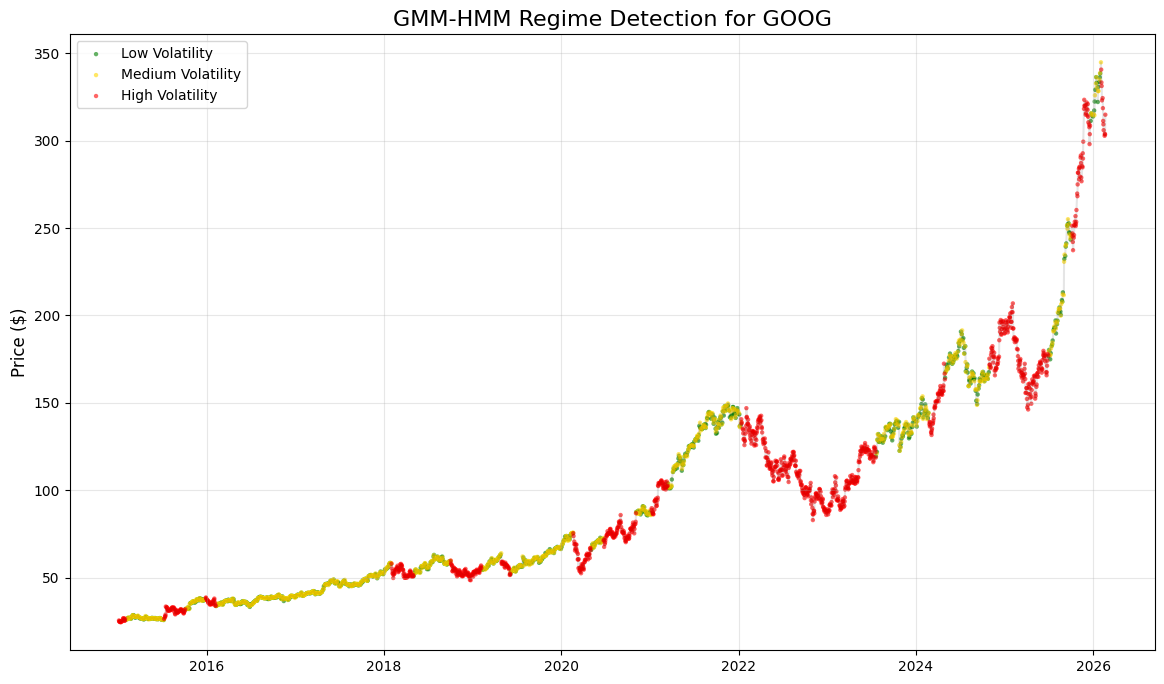


Transition Matrix (State i -> j):
[[4.21183245e-03 9.95782088e-01 6.07949671e-06]
 [9.45127879e-01 2.19779190e-02 3.28942016e-02]
 [2.16459021e-02 1.99017242e-03 9.76363925e-01]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0540 - val_loss: 0.6047
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6047 - val_loss: 0.5955
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5984 - val_loss: 0.6047
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5782 - val_loss: 0.6427
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5503 - val_loss: 0.6544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Predicted Daily Vol: 2.0336%
Predicted Annualized Vol: 32.2829%


/tmp/ipython-input-1011458918.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_regime = data["regime"][-1]
/tmp/ipython-input-1011458918.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1598766272.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for AAPL (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00189
  Weighted Vol (Std): 0.01097
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00126
  Weighted Vol (Std): 0.01385
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: -0.00051
  Weighted Vol (Std): 0.02556
------------------------------


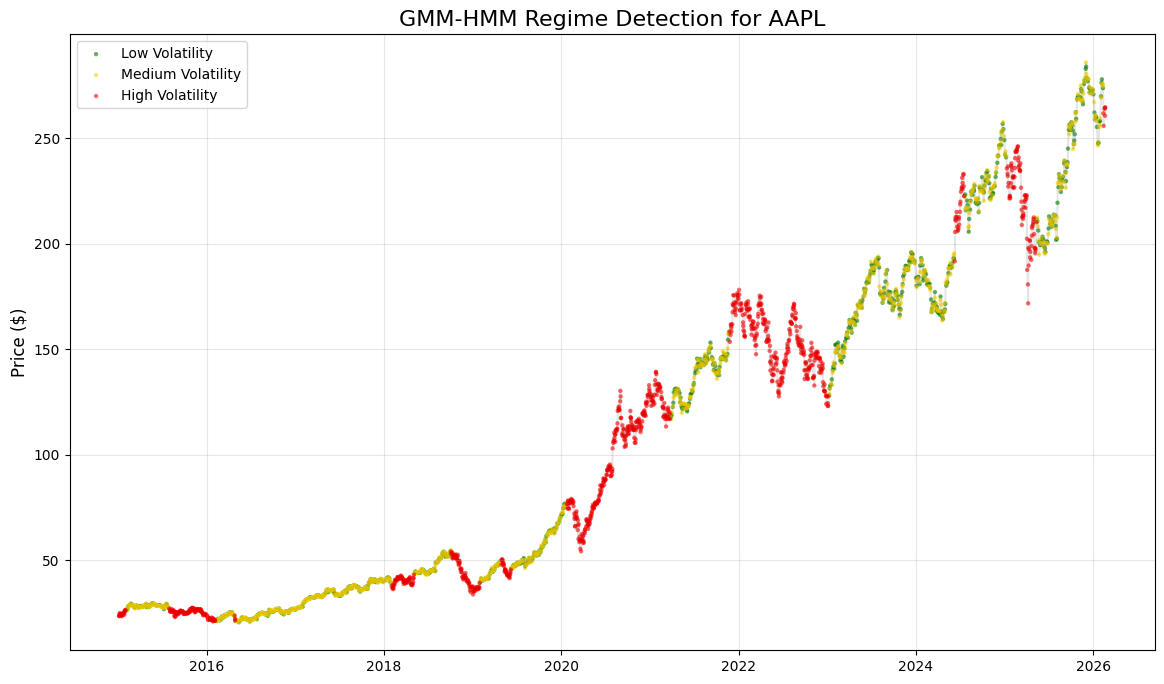


Transition Matrix (State i -> j):
[[1.29059498e-03 9.98646707e-01 6.26978055e-05]
 [9.72072429e-01 5.52040655e-03 2.24071644e-02]
 [1.21214031e-02 9.58961289e-03 9.78288984e-01]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.1352 - val_loss: 0.3517
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6199 - val_loss: 0.3514
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5953 - val_loss: 0.3659
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5836 - val_loss: 0.3701
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6145 - val_loss: 0.3589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Predicted Daily Vol: 1.1504%
Predicted Annualized Vol: 18.2626%


/tmp/ipython-input-1011458918.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_regime = data["regime"][-1]
/tmp/ipython-input-1011458918.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1598766272.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for KO (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: 0.00022
  Weighted Vol (Std): 0.00700
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: 0.00084
  Weighted Vol (Std): 0.00778
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: -0.00014
  Weighted Vol (Std): 0.01760
------------------------------


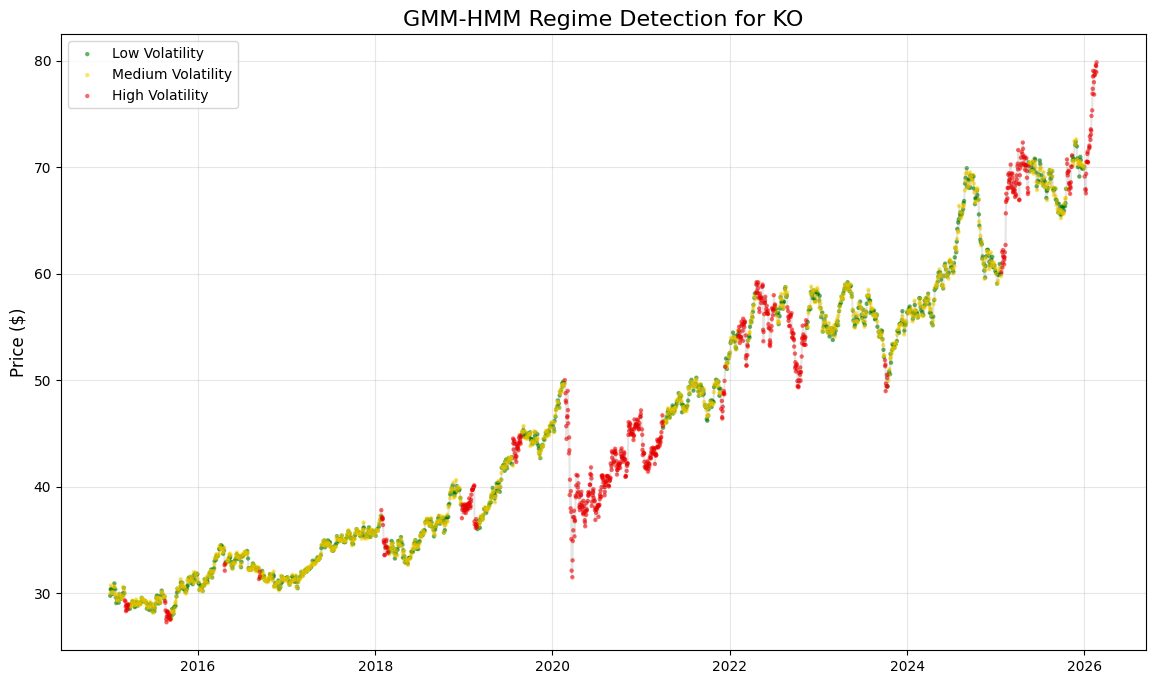


Transition Matrix (State i -> j):
[[3.65465343e-04 9.99634115e-01 4.19642581e-07]
 [9.66040303e-01 1.99410416e-03 3.19655925e-02]
 [4.12199551e-02 1.58263028e-03 9.57197415e-01]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6611 - val_loss: 0.2526
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3805 - val_loss: 0.2681
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3755 - val_loss: 0.2599
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3719 - val_loss: 0.2639
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3696 - val_loss: 0.2847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/tmp/ipython-input-1011458918.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_regime = data["regime"][-1]
/tmp/ipython-input-1011458918.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2015-01-01")
[*********************100%***********************]  1 of 1 completed

Predicted Daily Vol: 0.9905%
Predicted Annualized Vol: 15.7233%



/tmp/ipython-input-1598766272.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


--- Regime Parameters for TYO (GMM-HMM) ---
Regime 0 (Low Volatility):
  Weighted Mean: -0.00019
  Weighted Vol (Std): 0.00924
------------------------------
Regime 1 (Medium Volatility):
  Weighted Mean: -0.00047
  Weighted Vol (Std): 0.00970
------------------------------
Regime 2 (High Volatility):
  Weighted Mean: 0.00044
  Weighted Vol (Std): 0.01718
------------------------------


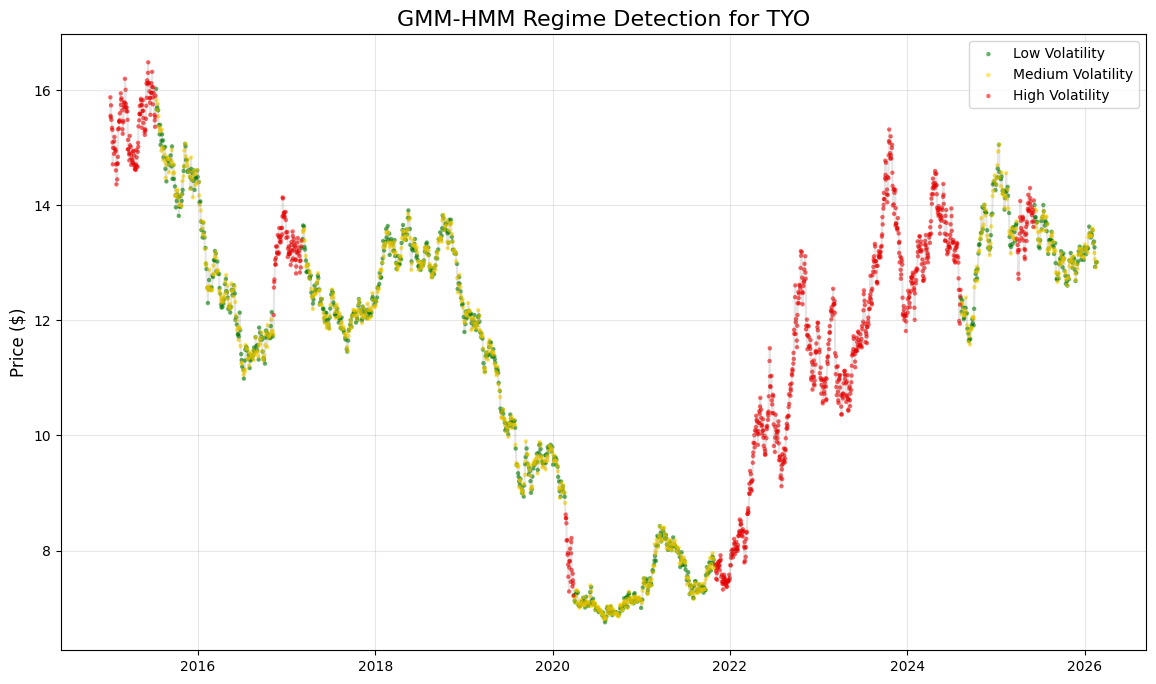


Transition Matrix (State i -> j):
[[2.65946252e-12 9.99999373e-01 6.26675918e-07]
 [9.92024566e-01 1.23490142e-11 7.97543398e-03]
 [9.07197216e-03 5.26962767e-06 9.90922758e-01]]
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6964 - val_loss: 0.5279
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4055 - val_loss: 0.5123
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3542 - val_loss: 0.5213
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3560 - val_loss: 0.5546
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3455 - val_loss: 0.5465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Daily Vol: 0.7881%
Predicted Annualized Vol: 12.5108%


/tmp/ipython-input-1011458918.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_regime = data["regime"][-1]


In [83]:
stocks = []
adding = True
while adding:
  temp = input("Enter a stock (Q to quit): ")
  if temp == "Q" or temp == "q":
    adding = False
  else:
    stocks.append(temp.upper()) # Convert to uppercase here
predicted_annual_volatilities = {}
transition_matrices = {}
probability_distributions = {}
current_regimes = {}

for stock in stocks:
  annualised_vol, transition_matrix, probability_distribution, current_regime = predict_next_day_volatility_annualised(stock)

  predicted_annual_volatilities[stock] = annualised_vol
  transition_matrices[stock] = transition_matrix
  probability_distributions[stock] = probability_distribution
  current_regimes[stock] = current_regime


In [84]:
price_data = yf.download(stocks, start="1900-01-01")["Close"]
returns_data = np.log(price_data / price_data.shift(1))
returns_data.dropna(inplace = True)
correlation_matrix = returns_data.corr()
D = np.diag(np.array(list(predicted_annual_volatilities.values()))/100)
future_variance_matrix = D @ correlation_matrix @ D
print("\n--- Future Covariance Matrix (Annualized) ---")
print(future_variance_matrix)

/tmp/ipython-input-1617422873.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(stocks, start="1900-01-01")["Close"]
[*********************100%***********************]  4 of 4 completed


--- Future Covariance Matrix (Annualized) ---
          0         1         2         3
0  0.104219  0.032084  0.016088  0.006160
1  0.032084  0.033352  0.008583  0.003386
2  0.016088  0.008583  0.024722  0.002168
3  0.006160  0.003386  0.002168  0.015652


Finding optimal weightings for stocks




In [85]:
returns = []
volatilities = []
allocations = []

num_stocks = len(stocks)
num_portfolios = 10000

mean_daily_returns = returns_data.mean()
mean_annual_returns = mean_daily_returns * 252
mean_annual_returns = mean_annual_returns[stocks]

In [86]:
for port in range(num_portfolios):
  w = np.random.random(num_stocks)
  w /= np.sum(w) #make it sum to 1
  allocations.append(w)
  returns.append(np.dot(w, mean_annual_returns))

  var = np.transpose(w).dot(future_variance_matrix).dot(w)
  standard_deviation = np.sqrt(var)
  volatilities.append(standard_deviation)

In [87]:
data2 = {"Returns":returns, "Volatilities": volatilities}
for counter, symbol in enumerate(stocks):
  data2[symbol + " Weight"] = [allocation[counter] for allocation in allocations]

portfolio = pd.DataFrame(data2)
portfolio

,Returns,Volatilities,GOOG Weight,AAPL Weight,KO Weight,TYO Weight
0,0.124005,0.137663,0.231064,0.251712,0.284654,0.232569
1,0.030024,0.107663,0.088414,0.184112,0.118128,0.609347
2,0.141536,0.126295,0.090492,0.431064,0.273506,0.204938
3,0.128452,0.138522,0.205222,0.182003,0.475002,0.137774
4,0.134816,0.159369,0.318824,0.095342,0.490036,0.095797
...,...,...,...,...,...,...
9995,0.152871,0.204081,0.531595,0.213950,0.043318,0.211137
9996,0.024229,0.108085,0.117302,0.099624,0.194678,0.588396
9997,0.053264,0.107133,0.100405,0.133333,0.317536,0.448726
9998,0.168528,0.151300,0.209857,0.299282,0.473199,0.017663


Below is a plot of the efficient frontier

<Axes: xlabel='Volatilities', ylabel='Returns'>

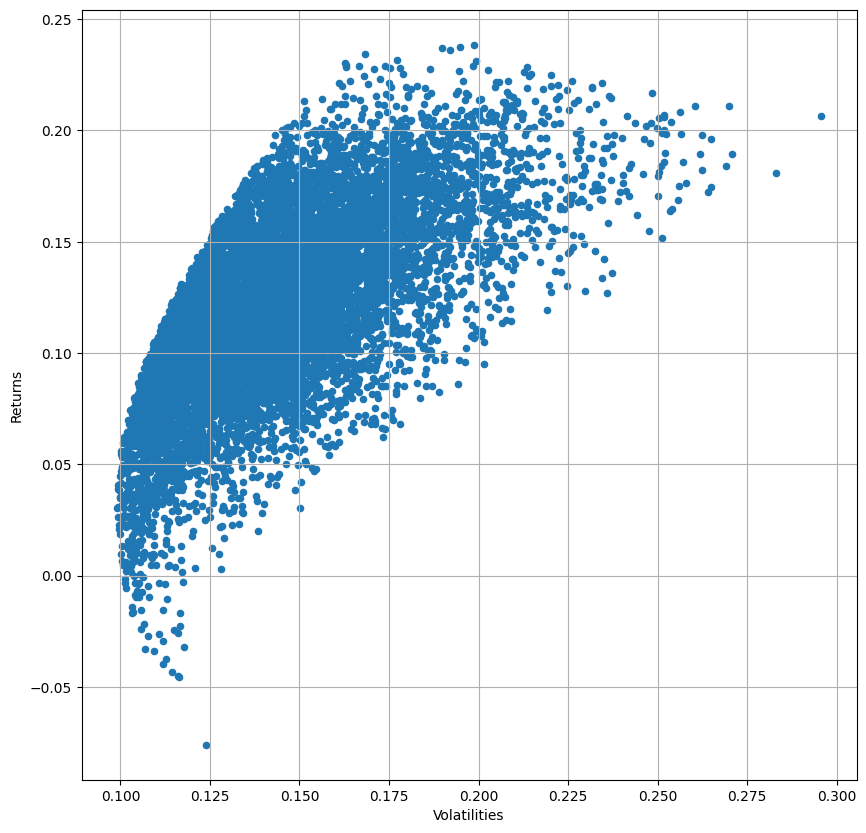

In [88]:
portfolio.plot.scatter(x = 'Volatilities', y = "Returns", figsize = (10,10), grid = True)


In [89]:
risk_free_rate = 0.04
highest_sharpe_ratio = portfolio.iloc[((portfolio["Returns"] - risk_free_rate)/portfolio["Volatilities"]).idxmax()]
highest_sharpe_ratio

,2109
Returns,0.230304
Volatilities,0.162632
GOOG Weight,0.007077
AAPL Weight,0.833115
KO Weight,0.157508
TYO Weight,0.002301


The portfolio with the highest sharpe ratio is marked below with a star

/tmp/ipython-input-2200269511.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x = highest_sharpe_ratio[1], y = highest_sharpe_ratio[0], color = "red", marker = "*", s = 500)


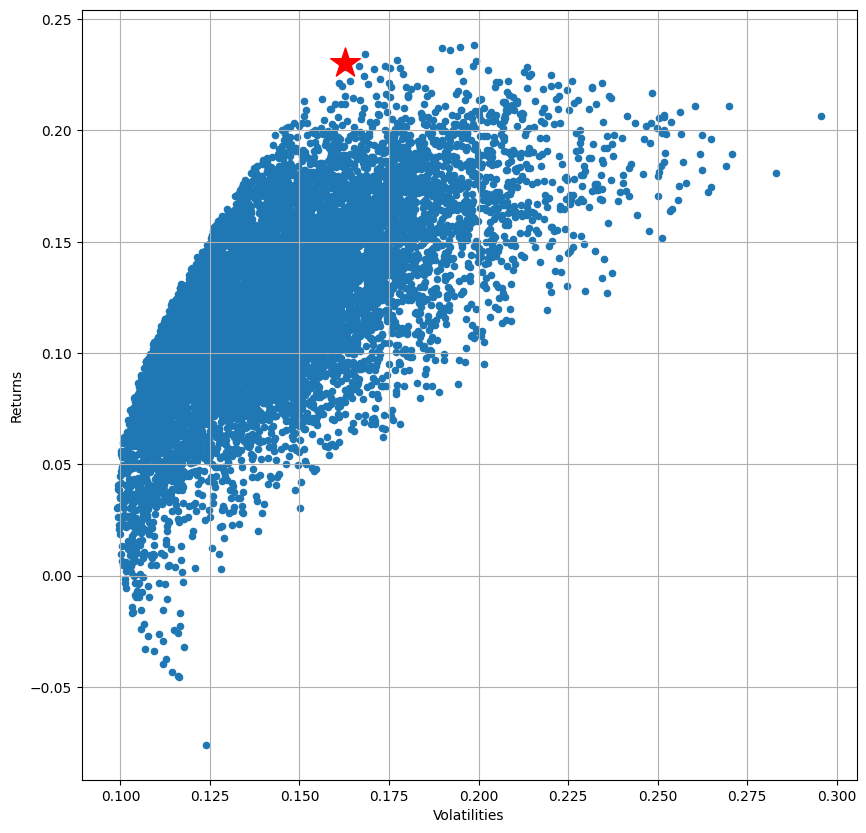

In [90]:
portfolio.plot.scatter(x = 'Volatilities', y = "Returns", figsize = (10,10), grid = True)
plt.scatter(x = highest_sharpe_ratio[1], y = highest_sharpe_ratio[0], color = "red", marker = "*", s = 500)


In [91]:
current_regimes

{'GOOG': np.float64(2.0),
 'AAPL': np.float64(2.0),
 'KO': np.float64(2.0),
 'TYO': np.float64(1.0)}

In [92]:
print(f"The expected returns for the portfolio with the highest sharpe ratio is: {highest_sharpe_ratio.iloc[0]*100}%")
print(f"The volatility for the portfolio with the highest sharpe ratio is: {highest_sharpe_ratio.iloc[1]*100}%")


The expected returns for the portfolio with the highest sharpe ratio is: 23.030439044723146%
The volatility for the portfolio with the highest sharpe ratio is: 16.263211107297302%


In [93]:
weights = highest_sharpe_ratio.iloc[2:].to_numpy()
weights_with_stock_name = dict(zip(stocks, weights)) #stock, weights
weights_with_stock_name

{'GOOG': np.float64(0.007076510095959875),
 'AAPL': np.float64(0.833114862748169),
 'KO': np.float64(0.15750804293969448),
 'TYO': np.float64(0.0023005842161764874)}

In [94]:
probability_distributions

{'GOOG': {'Mean': {'Low': np.float64(0.00013605152747810635),
   'Medium': np.float64(0.0029150260957428345),
   'High': np.float64(-2.338218929209604e-05)},
  'Standard Deviation': {'Low': np.float64(0.0107259544566931),
   'Medium': np.float64(0.013480201586439136),
   'High': np.float64(0.023898926456586637)}},
 'AAPL': {'Mean': {'Low': np.float64(0.001886424465947811),
   'Medium': np.float64(0.0012594035488795916),
   'High': np.float64(-0.0005054789464474851)},
  'Standard Deviation': {'Low': np.float64(0.010973498235856147),
   'Medium': np.float64(0.013845406061418963),
   'High': np.float64(0.0255639759630788)}},
 'KO': {'Mean': {'Low': np.float64(0.00022322669769842988),
   'Medium': np.float64(0.0008432016326963017),
   'High': np.float64(-0.00014164776418861108)},
  'Standard Deviation': {'Low': np.float64(0.007004876810921395),
   'Medium': np.float64(0.007784896985071442),
   'High': np.float64(0.017596877664454547)}},
 'TYO': {'Mean': {'Low': np.float64(-0.00019312581820

In [95]:
transition_matrices

{'GOOG': array([[4.21183245e-03, 9.95782088e-01, 6.07949671e-06],
        [9.45127879e-01, 2.19779190e-02, 3.28942016e-02],
        [2.16459021e-02, 1.99017242e-03, 9.76363925e-01]]),
 'AAPL': array([[1.29059498e-03, 9.98646707e-01, 6.26978055e-05],
        [9.72072429e-01, 5.52040655e-03, 2.24071644e-02],
        [1.21214031e-02, 9.58961289e-03, 9.78288984e-01]]),
 'KO': array([[3.65465343e-04, 9.99634115e-01, 4.19642581e-07],
        [9.66040303e-01, 1.99410416e-03, 3.19655925e-02],
        [4.12199551e-02, 1.58263028e-03, 9.57197415e-01]]),
 'TYO': array([[2.65946252e-12, 9.99999373e-01, 6.26675918e-07],
        [9.92024566e-01, 1.23490142e-11, 7.97543398e-03],
        [9.07197216e-03, 5.26962767e-06, 9.90922758e-01]])}

Monte Carlo Simulation Sampling wealth paths

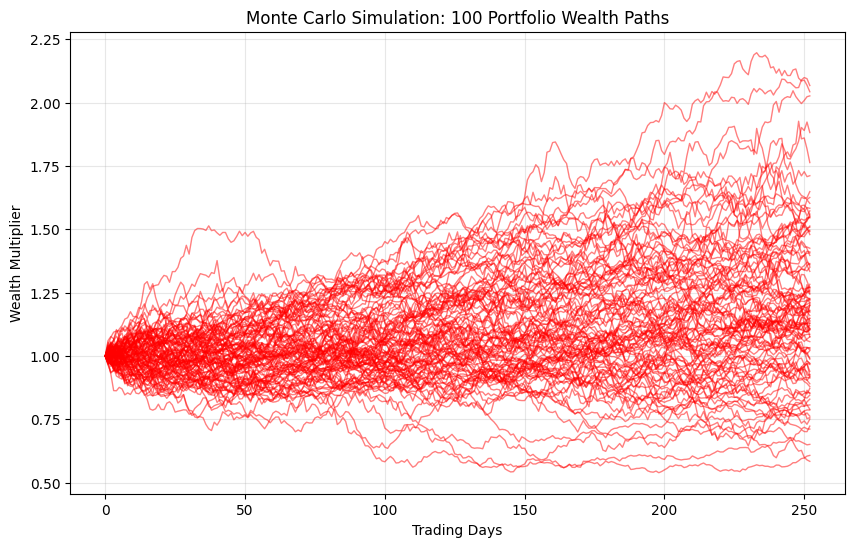

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mapping layers to handle the float representations
FLOAT_TO_STR = {0.0: "Low", 1.0: "Medium", 2.0: "High"}
STR_TO_FLOAT = {"Low": 0.0, "Medium": 1.0, "High": 2.0}
REGIME_STATES = [0.0, 1.0, 2.0] # The float states to sample from

def get_portfolio_return(current_regimes): #return for one day
    """Samples daily return for each stock and calculates the weighted portfolio return."""
    daily_portfolio_return = 0.0

    for stock, weight in weights_with_stock_name.items():
        # Get the regime float (e.g., 2.0) and map to string (e.g., "High")
        regime_float = current_regimes[stock]
        regime_str = FLOAT_TO_STR[float(regime_float)]

        mean = probability_distributions[stock]["Mean"][regime_str]
        std = probability_distributions[stock]["Standard Deviation"][regime_str]

        # Sample the individual stock's return for the day
        stock_return = np.random.normal(mean, std)

        # Add the weighted return to the portfolio total
        daily_portfolio_return += (stock_return * weight)

    return daily_portfolio_return #return for one day

def update_regimes(current_regimes):
    """Transitions each stock to its next regime based on its specific Markov matrix."""
    new_regimes = {}

    for stock in weights_with_stock_name.keys():
        # Convert float (e.g., 2.0) to int (2) to index the transition matrix array
        matrix_row_idx = int(current_regimes[stock])

        # Fetch the transition probabilities for the stock's current state
        probabilities = transition_matrices[stock][matrix_row_idx]

        # Determine tomorrow's regime, saving it back as a float
        new_regimes[stock] = np.random.choice(REGIME_STATES, p=probabilities)

    return new_regimes

def simulate_portfolio_year(start_wealth, current_regimes):
    """Simulates one path of the portfolio for 252 trading days."""
    wealth_path = [start_wealth]
    current_wealth = start_wealth

    num_simulations = 252
    for _ in range(num_simulations):
        # 1. Get today's weighted portfolio return
        daily_ret = get_portfolio_return(current_regimes)

        # 2. Update wealth
        current_wealth *= (1 + daily_ret)
        wealth_path.append(current_wealth)

        # 3. Transition regimes for tomorrow
        current_regimes = update_regimes(current_regimes)

    return wealth_path

def monte_carlo(num_paths=100):
    """Runs multiple simulations and plots the distribution of wealth paths."""
    plt.figure(figsize=(10, 6))

    for _ in range(num_paths):
        path = simulate_portfolio_year(1.0, current_regimes)
        plt.plot(path, color='red', alpha=0.5, linewidth=1)

    plt.title(f"Monte Carlo Simulation: {num_paths} Portfolio Wealth Paths")
    plt.xlabel("Trading Days")
    plt.ylabel("Wealth Multiplier")
    plt.grid(True, alpha=0.3)

    plt.show()

# Run the simulation
monte_carlo(num_paths=100)